In [1]:
import torch 
import random 
from mlca_for_elec.networks.main import eval_config
import os
import matplotlib.pyplot as plt
from mlca_for_elec.env.env import Microgrid, HouseHold
import json
import numpy as np

In [2]:
def evaluate_network(cfg: dict, seed: int, MicroGrid_instance: str, bidder_id: str, num_train_data: int, layer_type: str,
                     normalize: bool, normalize_factor: float, eval_test=False, save_datasets=False):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return eval_config(
        seed=seed, SAT_instance=MicroGrid_instance, bidder_id=bidder_id,
        layer_type=layer_type, batch_size=cfg['batch_size'], num_hidden_layers=cfg['num_hidden_layers'],
        num_hidden_units=int(max(1, np.round(cfg['num_neurons'] / cfg['num_hidden_layers']))), l2=cfg['l2'],
        lr=cfg['lr'], normalize_factor=normalize_factor, optimizer=cfg['optimizer'], num_train_data=num_train_data,
        eval_test=True, epochs=cfg['epochs'], loss_func=cfg['loss_func'], normalize=normalize, save_datasets=False, log_path="logs", ts = cfg["ts"])

In [3]:
%matplotlib inline
print("Start loading household profiles")
folder_path = "../config\household_profile\\"
houses = []
for file in os.listdir(folder_path)[:3]:
    if file.endswith(".json"):
        household = json.load(open(folder_path+"/"+ file))
    house = HouseHold(household)

    generation_path = "../data\solar_prod\Timeseries_55.672_12.592_SA2_1kWp_CdTe_14_44deg_-7deg_2020_2020.csv"
    consumption_path = f"../data/consumption/Reference-{house.param['consumption']['type']}.csv"
    spot_price_path = "../data/spot_price/2020.csv"
    fcr_price_path = "../data/fcr_price/random_fcr.csv"
    profile_path = "../data\cost_function\dataset_0.csv"
    house.load_data(generation_path,consumption_path, spot_price_path,fcr_price_path, profile_path)
    for i in range(205):
        house.next_data()
    houses.append(house)
print(f"Loaded {len(houses)} households")
print("Start compute social welfare")
print(houses[0].data['consumption'])
microgrid_1 =json.load(open("../config\microgrid_profile\default_microgrid.json"))
MG = Microgrid(houses, microgrid_1)
# MG.generate_dataset(0)
config_dict = {"batch_size": 1,
        "epochs":20,
        "l2": 1e-5,
        "loss_func": "F.l1_loss",
        "lr": 0.0001,
        "num_hidden_layers":3,
        "num_neurons": 500,
        "optimizer": "Adam"
    }

print('Selected hyperparameters', config_dict)
model, logs = evaluate_network(
    config_dict, seed=0, MicroGrid_instance=MG, bidder_id=1,
    num_train_data=50, layer_type="PlainNN",
    normalize=True,
    normalize_factor= 0.9)
train_logs = logs['metrics']['train'][config_dict['epochs']]
val_logs = logs['metrics']['val'][config_dict['epochs']]
test_logs = logs['metrics']['test'][config_dict['epochs']]

print('Train metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(train_logs['r'], train_logs['kendall_tau']))
print('Valid metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(val_logs['r'], val_logs['kendall_tau']))
print('Test metrics \t| pearson corr.: {:.3f}, KT: {:.3f}'.format(test_logs['r'], test_logs['kendall_tau']))

Start loading household profiles
0
1
2
Loaded 3 households
Start compute social welfare
0     26.0
1     24.0
2     23.0
3     24.0
4     29.0
5     47.0
6     61.0
7     50.0
8     47.0
9     39.0
10    41.0
11    43.0
12    40.0
13    39.0
14    38.0
15    45.0
16    54.0
17    71.0
18    75.0
19    85.0
20    80.0
21    64.0
22    45.0
23    35.0
Name: consumption, dtype: float64
Selected hyperparameters {'batch_size': 1, 'epochs': 20, 'l2': 1e-05, 'loss_func': 'F.l1_loss', 'lr': 0.0001, 'num_hidden_layers': 3, 'num_neurons': 500, 'optimizer': 'Adam'}


KeyError: 'ts'

Selected hyperparameters {'batch_size': 1, 'epochs': 200, 'l2': 1e-05, 'loss_func': 'F.l1_loss', 'lr': 0.0001, 'num_hidden_layers': 2, 'num_neurons': 175, 'optimizer': 'Adam', 'ts': 1}
(1000, 25)
(50, 24) (50,) (200, 24) (200,) (750, 24) (750,)


100%|██████████| 200/200 [00:59<00:00,  3.37it/s]


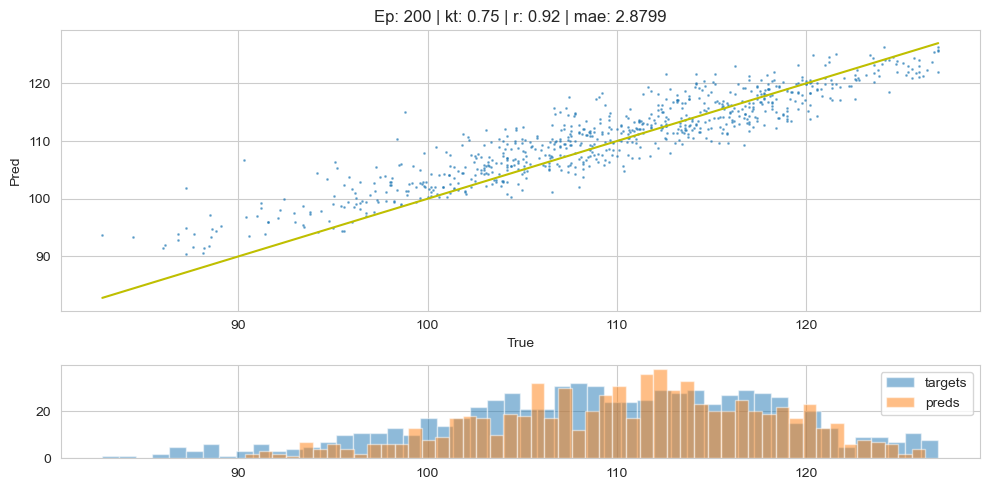

Train metrics 	| mae: 1.013, pearson corr.: 0.982, KT: 0.909
Valid metrics 	| mae: 2.852, pearson corr.: 0.927, KT: 0.745
Test metrics 	| mae: 2.880, pearson corr.: 0.922, KT: 0.748


In [50]:
%matplotlib inline
import itertools as iter 
lr_min, lr_max = 0.00005,0.0005
num_hidden_layers_min,num_hidden_layers_max= 2,3
num_neurons_min, num_neurons_max = 175,300
epochs_min, epochs_max = 200,200
penal_min, penal_max= 1e-5,1e-5
batch_size_min, batch_size_max = 1,4
normalize_factor = 1

lr_range = np.linspace(lr_min, lr_max, 1)
num_hidden_layers_range = np.linspace(num_hidden_layers_min, num_hidden_layers_max, 1, dtype = int)
num_neurons_range = np.linspace(num_neurons_min, num_neurons_max, 1, dtype = int)
epochs_range = np.linspace(epochs_min, epochs_max, 1, dtype = int)
batch_size_range = np.linspace(batch_size_min, batch_size_max, 1, dtype = int)
penal_range = np.linspace(penal_min, penal_max, 1)

def grid_search(lr_range, num_hidden_layers_range, num_neurons_range, epochs_range, batch_size_range, penal_range): 
    results = [] 
    best_result = (np.inf,None,None)
    for lr, num_hidden_layers, num_neurons, epochs, batch_size, penalty in iter.product(lr_range,num_hidden_layers_range,num_neurons_range,epochs_range,batch_size_range, penal_range):
        config_dict = {"batch_size": 1,
            "epochs":epochs,
            "l2": penalty,
            "loss_func": "F.l1_loss",
            "lr": 0.0001,
            "num_hidden_layers":num_hidden_layers,
            "num_neurons": num_neurons,
            "optimizer": "Adam", "ts":1
        }
        print('Selected hyperparameters', config_dict)
        model, logs = evaluate_network(
                            config_dict, seed=0, MicroGrid_instance=MG, bidder_id=1,
                            num_train_data=30,layer_type="CALayerReLUProjected",
                            normalize=True,
                            normalize_factor= normalize_factor)
        train_logs = logs['metrics']['train'][config_dict['epochs']]
        val_logs = logs['metrics']['val'][config_dict['epochs']]
        test_logs = logs['metrics']['test'][config_dict['epochs']]
        print('Train metrics \t| mae: {:.3f}, pearson corr.: {:.3f}, KT: {:.3f}'.format(train_logs['mae'], train_logs['r'], train_logs['kendall_tau']))
        print('Valid metrics \t| mae: {:.3f}, pearson corr.: {:.3f}, KT: {:.3f}'.format(val_logs['mae'], val_logs['r'], val_logs['kendall_tau']))
        print('Test metrics \t| mae: {:.3f}, pearson corr.: {:.3f}, KT: {:.3f}'.format(test_logs['mae'], test_logs['r'], test_logs['kendall_tau']))
        if test_logs['mae'] < best_result[0]:
            best_result = (test_logs['mae'], config_dict, model)
        results.append((config_dict, train_logs, val_logs, test_logs))
    return results, best_result

        
results, best_result = grid_search(lr_range, num_hidden_layers_range, num_neurons_range, epochs_range, batch_size_range, penal_range)

In [45]:
best_result

(1.8668943589925766,
 {'batch_size': 1,
  'epochs': 150,
  'l2': 1e-05,
  'loss_func': 'F.l1_loss',
  'lr': 0.0001,
  'num_hidden_layers': 1,
  'num_neurons': 100,
  'optimizer': 'Adam',
  'ts': 1},
 Net(
   (output_activation_function): Identity()
   (layers): ModuleList(
     (0): CALayerReLUProjected(in_features=24, out_features=100, bias=True)
   )
   (output_layer): CALayerReLUProjected(in_features=100, out_features=1, bias=False)
 ))

In [46]:
bids=[]
for n in range(200000):
    bids.append(np.random.rand(24)*6
                )
synth_bids= np.asarray(bids)
# synth_bids = np.vstack((synth_bids_1,synth_bids_2,synth_bids_3))

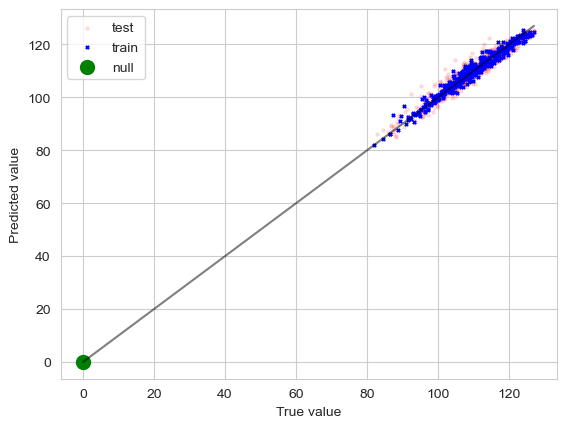

In [48]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
best_model = best_result[2]
profile = pd.read_csv("../data\cost_function\dataset_0.csv")
bids = profile.to_numpy()[:,1:-1]
value = profile.to_numpy()[:,-1]
n_item = 400

bids_train = torch.Tensor(bids[:n_item])
bids_test = torch.Tensor(bids[n_item:])
null_test = torch.zeros_like(bids_test[1])

target_train = value[:n_item]
target_max = target_train.max()* (1 / normalize_factor)
target_test = value[n_item:]
target_synth =list (map(lambda x : calculate_value(x), synth_bids))

# Scale targets
target_train = target_train /target_max
target_test = target_test /target_max
target_synth = target_synth / target_max

pred_train = best_model(bids_train)
pred_test = best_model(bids_test)
pred_null = best_model(null_test)
pred_synth = best_model(torch.Tensor(synth_bids))
#plt.xlim(-0.1, target_max*1.1)#
# plt.ylim(-0.1, target_max*1.1)#
dat_min, dat_max = min(min(pred_train), min(target_train)), \
                           max(max(pred_train), max(target_train))
plt.plot([0,target_train.max()*target_max], [0, normalize_factor*target_max], color = "black", alpha=0.5)
#plt.plot([dat_min, dat_max], [dat_min, dat_max], 'y')
plt.scatter(target_test*target_max, pred_test.detach().numpy()*target_max, label = "test", marker="o", color = "r", alpha=0.1,s=5)
# plt.scatter(target_synth*target_max, pred_synth.detach().numpy()*target_max, marker="o", color = "r", alpha =0.1, s=5)
plt.scatter(target_train*target_max, pred_train.detach().numpy()*target_max, label = "train", marker="x", color = "b", s=5)
plt.scatter(0, pred_null.detach().numpy()*target_max, label = "null", marker="o", color = "g", s=100)
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.legend()
plt.show()


In [9]:
conso = [1.7103, 1.5880,    1.1542,    1.0839,    1.3647,    1.5383,    1.9894,    1.8424,    1.6247,
    1.6449,
    2.0100,
    2.1101,
    2.0926,
    2.1760,
    2.3454,
    3.6615,
    4.8890,
    5.5265,
    5.4207,
    5.8789,
    5.0104,
    3.8021,
    2.5621,
   1.6879]

In [10]:
def calculate_value(bid):
    return sum(map(lambda x: min(x[0],x[1])*0.2, zip(bid, conso)))
def calculate_value_inf(bid):
    return sum(map(lambda x: min(x[0],np.inf)*0.2, zip(bid, conso)))
calculate_value(bids[1]), 

(12.942800000000002,)

In [11]:
X,Y = np.meshgrid(np.linspace(0,6,100),np.linspace(0,6,100))
C= 0*np.zeros((100,100))
C_opt= 0*np.zeros((100,100))
vec =14*np.ones(24)
for i in range(100):
    for j in range(100):
            vec[0] = X[i,j]
            vec[1] = Y[i,j]
            C[i,j] = best_model(torch.tensor(vec).float()).detach().numpy()*target_max
            C_opt[i,j] = calculate_value(vec)

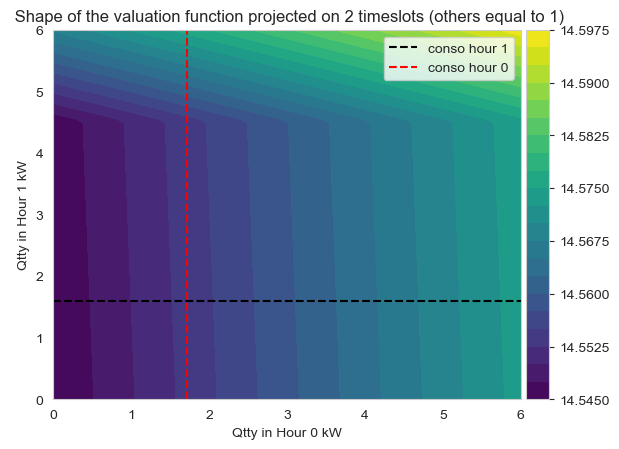

In [137]:
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure()
ax = fig.add_subplot()
#ax.contour(X, Y, C, levels =20)
c = ax.contourf(X, Y, C, levels =20, cmap="viridis")
ax.set_xlabel('Qtty in Hour 0 kW')
ax.set_ylabel('Qtty in Hour 1 kW')
ax.axhline(conso[1], color = "black", label = "conso hour 1", linestyle="--")
ax.axvline(conso[0], color = "red", label = "conso hour 0", linestyle="--")

ax.legend()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')
ax.set_title(" Shape of the valuation function projected on 2 timeslots (others equal to 1)")
plt.show()